In [1]:
from make_prediction import DataSplits

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import seaborn as sns
sns.set()

In [4]:
data = pd.read_pickle("predictions.pkl")

In [5]:
import weighted_ks

In [6]:
import concurrent.futures
import multiprocessing

In [10]:
def distance(sample1, sample2, w1, w2, n_iterations=100):
    assert len(sample1) == len(w1)
    assert len(sample2) == len(w2)
    assert w1.ndim == w2.ndim == 1
    assert sample1.ndim == sample2.ndim == 2
    assert sample1.shape[1] == sample2.shape[1]

    def single_iteration_(dummy):
        del dummy
        direction = np.random.normal(size=(1, sample1.shape[1]))
        return weighted_ks.ks_2samp_w(
                         (sample1 * direction).sum(axis=1),
                         (sample2 * direction).sum(axis=1),
                         w1, w2
                     )
    with concurrent.futures.ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
        result = max(executor.map(single_iteration_, range(n_iterations)))

    return result

In [7]:
import utils_rich_mrartemev as utils_rich

In [8]:
X_cols = utils_rich.raw_feature_columns
Y_cols = utils_rich.dll_columns
w_col  = utils_rich.weight_col
pred_cols = ["predicted_{}".format(col) for col in Y_cols]

In [9]:
from tqdm import tqdm_notebook as tqdm
from itertools import combinations

In [ ]:
distances = dict()
for particle, df in data.items():
    all_dfs = dict(
        real_train=(df.train[X_cols + Y_cols], df.train[w_col]),
        real_val  =(df.val  [X_cols + Y_cols], df.val  [w_col]),
        real_test =(df.test [X_cols + Y_cols], df.test [w_col]),
        gen_train=(df.train[X_cols + pred_cols], df.train[w_col]),
        gen_val  =(df.val  [X_cols + pred_cols], df.val  [w_col]),
        gen_test =(df.test [X_cols + pred_cols], df.test [w_col])
    )
    print(particle)
    distances[particle] = {
        (s1, s2) : distance(df1.values, df2.values, w1.values, w2.values)
        for (s1, (df1, w1)), (s2, (df2, w2)) in tqdm(combinations(all_dfs.items(), 2))
    }
    for k, v in distances[particle].items():
        print(k, v)

pd.to_pickle(distances, 'distances.pkl')

In [11]:
import time

In [12]:
def get_percentile_range(array, weights, percentile):
    ix = np.argsort(array)
    array, weights = array[ix], weights[ix]
    cdf = weights.cumsum()
    cdf /= cdf[-1]
    i_left_rev = np.argmax(cdf[::-1] < percentile)
    i_right = np.argmax(cdf > 1. - percentile)
    left = array[::-1][i_left_rev]
    right = array[i_right]
    return left, right

def get_range(weights, *arrays, percentile=0.01):
    lefts, rights = zip(
        *[get_percentile_range(arr, weights, percentile) for arr in arrays]
    )
    return min(lefts), max(rights)

def plot_hist_real_vs_gen(df, col, ax=None, selection=None, n_bins=None, linear=True):
    predicted_col = "predicted_{}".format(col)

    if selection is not None:
        df = df[selection]
    
    real = df[col].values
    gen  = df[predicted_col].values
    w = df[utils_rich.weight_col].values

    if n_bins is None:
        n_bins = np.floor(w.sum()**0.5 / 4).astype(int)
    
    bins = np.linspace(
        *get_range(w, real, gen, percentile=0.01 if linear else 0.),
        n_bins + 1
    )
    
    if ax is None:
        fig, ax = plt.subplots()

    ax.hist(real, weights=w, bins=bins, label='real')
    ax.hist(gen , weights=w, bins=bins, label='gen', alpha=0.5)
    if not linear:
        ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel(col)

In [13]:
from itertools import product

def make_bins_selection(df, bins_dict, cols=None):
    if cols is None:
        cols = [col for col in bins_dict.keys()]
    
    features = df[cols].values
    
    bins_nd = [bins_dict[col] for col in cols]
    bins_left  = [[l for l in bins[:-1]] for bins in bins_nd]
    bins_right = [[r for r in bins[1: ]] for bins in bins_nd]

    shape = [len(bins) - 1 for bins in bins_nd]
    shape.append(len(df))
    
    selection = np.array(
        [(features >= lefts).all(axis=1) & (features <= rights).all(axis=1)
         for lefts, rights in zip(product(*bins_left), product(*bins_right))]
    )
    selection_labels = np.array(
        [['{:.3} <= {} <= {:.3}'.format(l, name, r) for name, l, r in zip(cols, lefts, rights)]
         for lefts, rights in zip(product(*bins_left), product(*bins_right))]
    )
    selection_labels = selection_labels.reshape(*shape[:-1], -1)
    selection = selection.reshape(shape)
    return selection, selection_labels

In [14]:
def get_quantiles(arr, w, n):
    ix = np.argsort(arr)
    arr, w = arr[ix], w[ix]
    cdf = w.cumsum()
    cdf /= cdf[-1]
    thresholds = np.arange(n + 1, dtype=float) / n
    ids = np.argmax(cdf[:,np.newaxis] >= thresholds[np.newaxis,:], axis=0)
    return arr[ids]

In [15]:
df = data['kaon'].test

bins_dict = dict(
    Brunel_ETA=get_quantiles(df.Brunel_ETA.values,
                             df[utils_rich.weight_col].values, 8),
    Brunel_P  =get_quantiles(df.Brunel_P.values,
                             df[utils_rich.weight_col].values, 8)
)
bin_cols = ['Brunel_P', 'Brunel_ETA']

selection, labels = make_bins_selection(df, bins_dict, bin_cols)

In [16]:
def plot_in_bins_2d(function, selection, labels,
                    figsize=(15, 10),
                    min_samples=50,
                    fontsize=15,
                    **params):
    assert selection.ndim == 3
    
    fig, axxx = plt.subplots(selection.shape[0], selection.shape[1], figsize=figsize)
    
    for i_row, axx in enumerate(axxx):
        for i_col, ax in enumerate(axx):
            sel = selection[i_row, i_col]
            if sel.sum() > min_samples:
                function(**params, ax=ax, selection=sel)
                ax.text(0.5, 1.0, labels[i_row][i_col][1],
                        bbox={'facecolor':'white', 'pad':3},
                        transform=ax.transAxes,
                        horizontalalignment='center',
                        fontsize=fontsize)
                
                ax.text(0.0, 0.5, labels[i_row][i_col][0],
                        bbox={'facecolor':'white', 'pad':3},
                        transform=ax.transAxes,
                        verticalalignment='center',
                        rotation='vertical',
                        fontsize=fontsize)
            else:
                ax.axis('off')
    fig.tight_layout()

In [17]:
plt.rcParams["patch.force_edgecolor"] = False

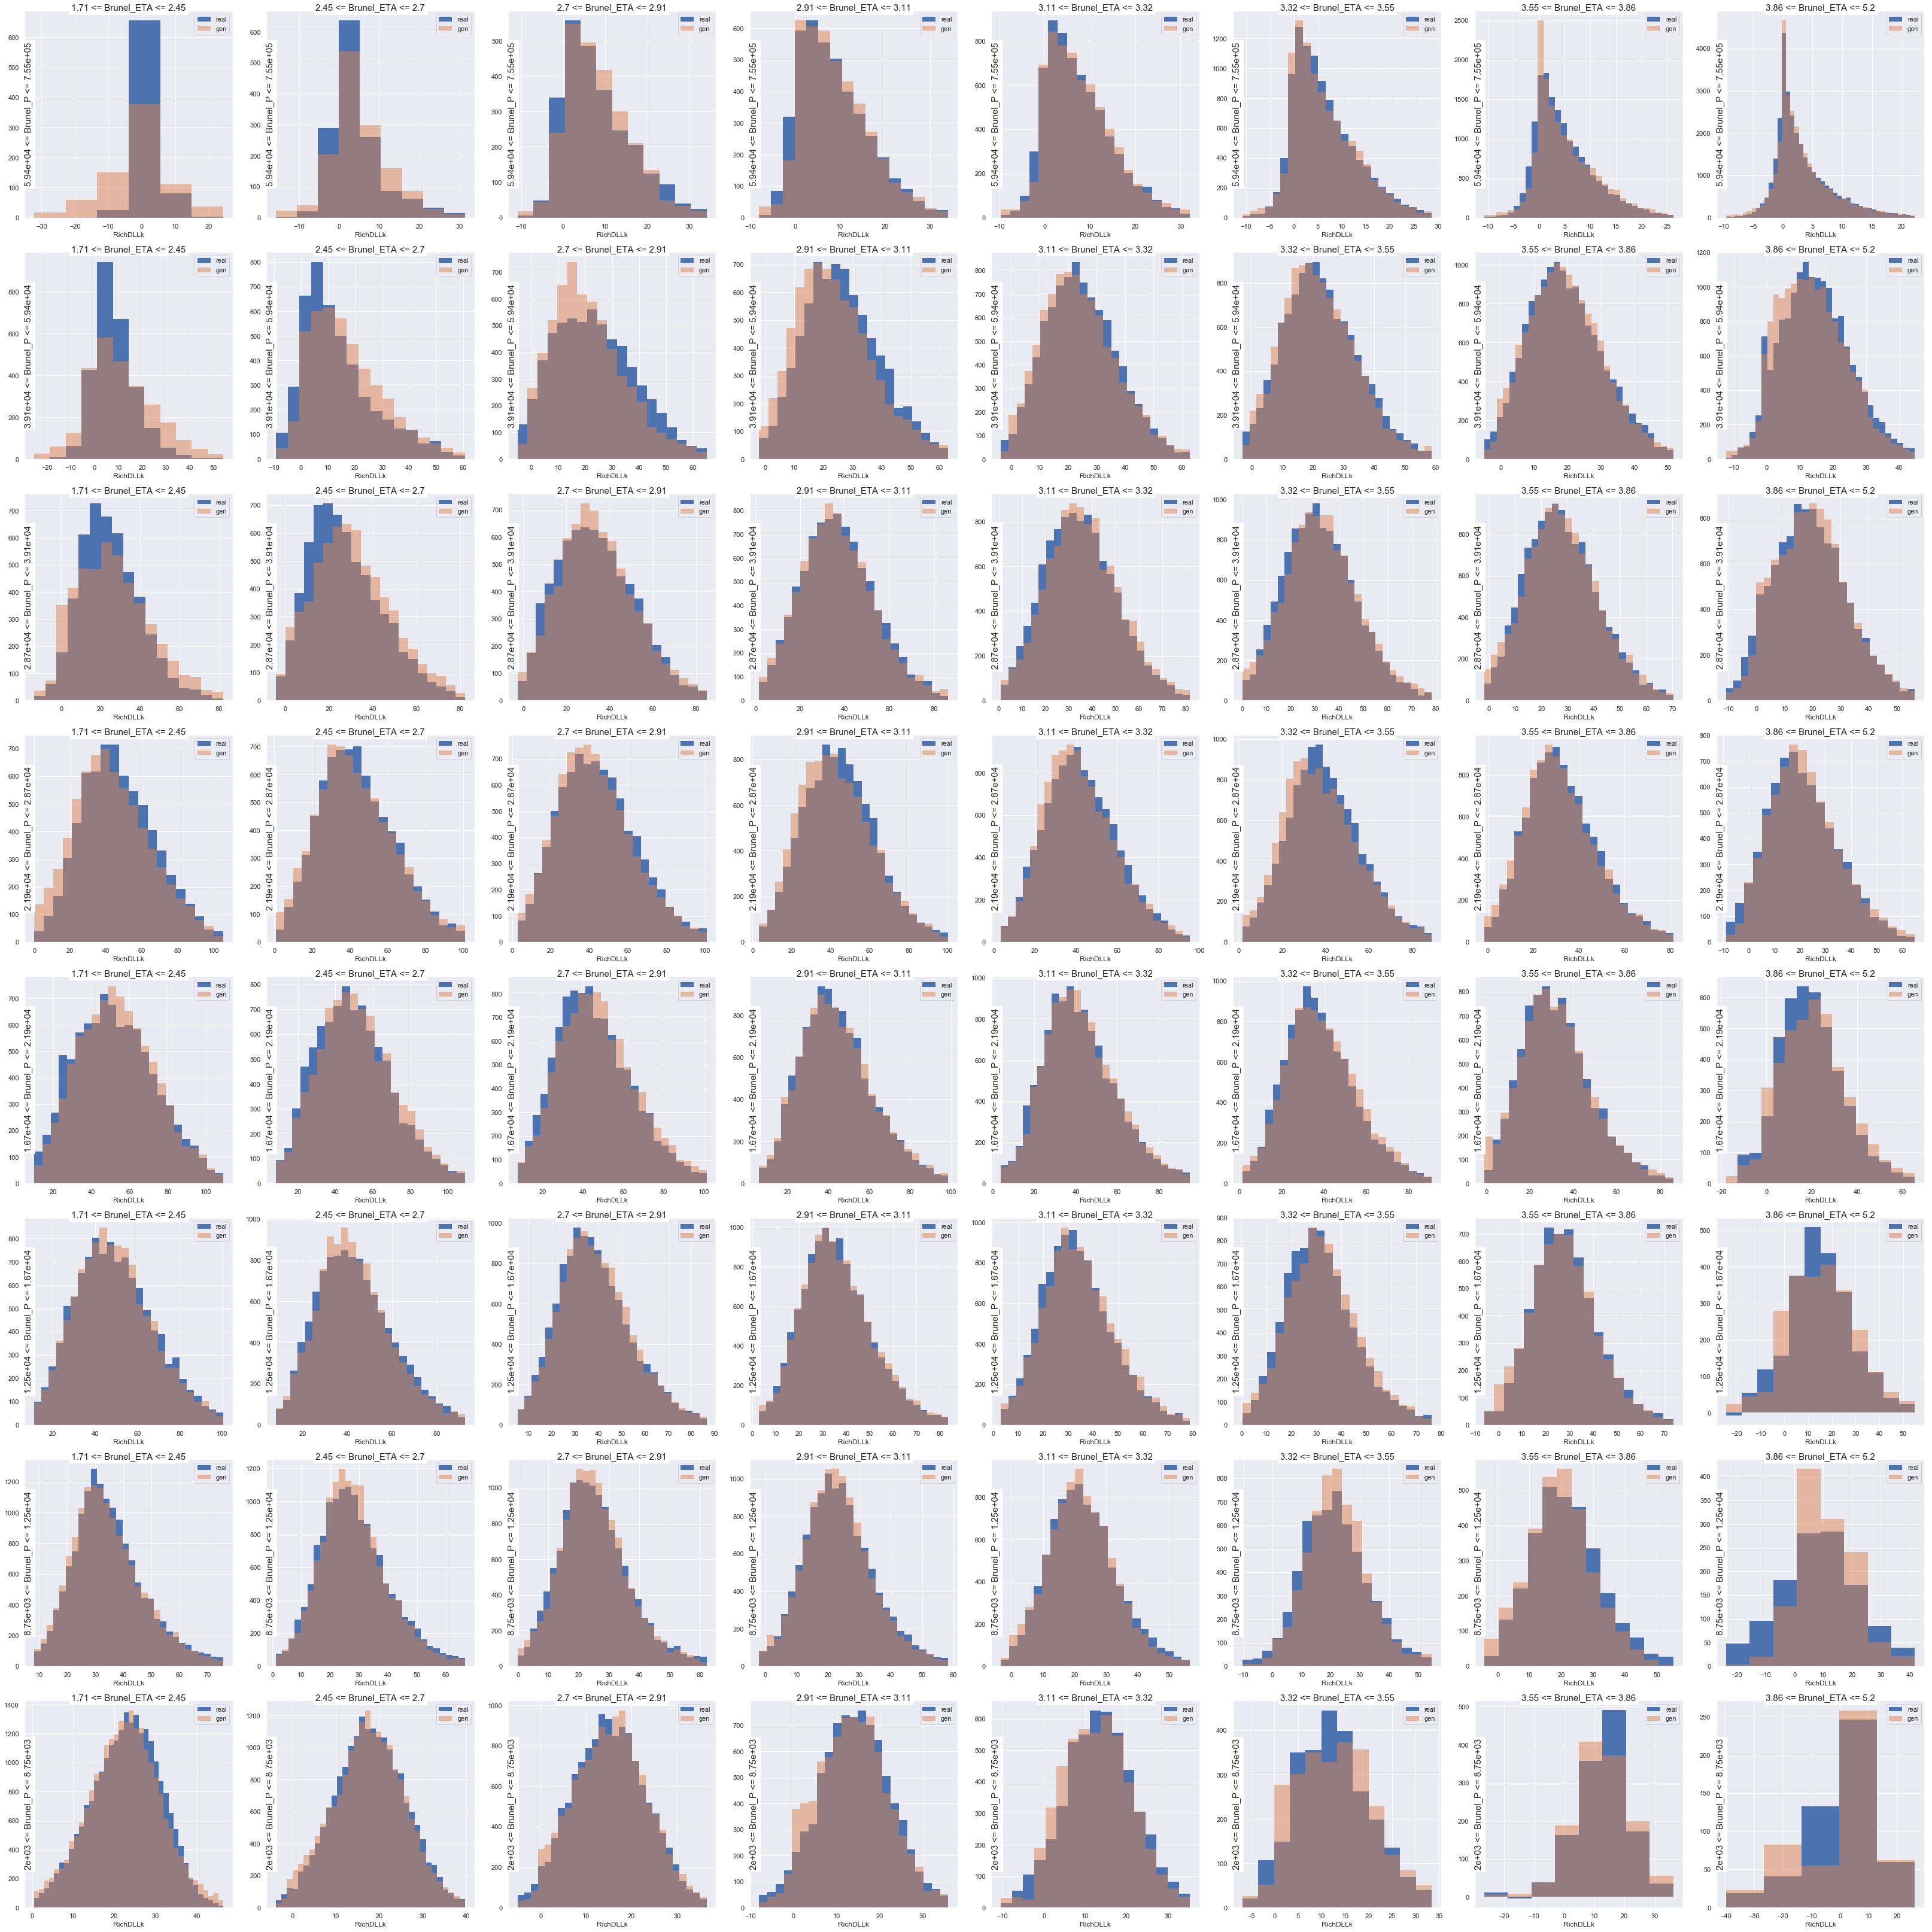

In [18]:
plot_in_bins_2d(plot_hist_real_vs_gen, selection[::-1], labels[::-1], figsize=(45, 45), df=df, col='RichDLLk')